In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [3]:
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',1000)


from google.colab import drive
drive.mount('/content/drive')

path_train = "drive/MyDrive/Colab Notebooks/train.csv"
path_test = "drive/MyDrive/Colab Notebooks/test.csv"
path_spray = "drive/MyDrive/Colab Notebooks/spray.csv"
path_weather = "drive/MyDrive/Colab Notebooks/weather.csv"

train_df = pd.read_csv(path_train)
test_df = pd.read_csv(path_test)
spray_df = pd.read_csv(path_spray)
weather_df = pd.read_csv(path_weather)
train_df.head(10)

Mounted at /content/drive


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0
5,2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",CULEX RESTUANS,15,W WEBSTER AVE,T045,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,2,0
6,2007-05-29,"2500 West Grand Avenue, Chicago, IL 60654, USA",CULEX RESTUANS,25,W GRAND AVE,T046,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,1,0
7,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,1,0
8,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2,0
9,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,1,0


In [5]:
# On remplace les données manquantes ('M', '-') par None
weather_df.replace(['M', '-'], np.nan, inplace=True)
print(weather_df.isnull().sum())

Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
Depart         1472
DewPoint          0
WetBulb           4
Heat             11
Cool             11
Sunrise        1472
Sunset         1472
CodeSum           0
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64


In [6]:
# Remplacer NaN par la moyenne de chaque colonne
col = ['Tavg', 'Depart', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'AvgSpeed']
for column in col:
        weather_df[column] = pd.to_numeric(weather_df[column], errors='coerce')
        mean_value = weather_df[column].mean()
        weather_df[column].fillna(mean_value, inplace=True)

# Features gênantes pour l'entrainement du modèle (de type object) pourront potentiellement être ajoutée après
weather_df = weather_df.drop(['Water1', 'CodeSum'], axis=1)
# Vérification qu'il n'y a plus de valeurs non définie
print(weather_df.isnull().sum())

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
Depth          0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64


In [7]:
target = train_df['WnvPresent']

In [8]:
# dropping the target and the localisation features
train = train_df.drop(["WnvPresent", "Address", "AddressNumberAndStreet", "Street", "Trap"], axis=1)

# latitude and longitude of the 2 existing stations
station1 = (41.995, -87.933)
station2 = (41.786, -87.752)

def euclidean_distance(lat1, lon1, lat2, lon2):
    return np.sqrt((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2)

# find the closest station relative to the current latitude and longitude of the individual (row of our dataset)
def closest_station(row):
    dist_to_station1 = euclidean_distance(row['Latitude'], row['Longitude'], station1[0], station1[1])
    dist_to_station2 = euclidean_distance(row['Latitude'], row['Longitude'], station2[0], station2[1])
    return 1 if dist_to_station1 < dist_to_station2 else 2

# Create a news columns filled with either 1 or 2 to display if the row is more close to the station 1 or 2
train['Station'] = train.apply(closest_station, axis=1)

# dropping localisation features
train = train.drop(["Latitude", "Longitude"], axis=1)

train

,Date,Species,Block,AddressAccuracy,NumMosquitos,Station
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,9,1,1
1,2007-05-29,CULEX RESTUANS,41,9,1,1
2,2007-05-29,CULEX RESTUANS,62,9,1,1
3,2007-05-29,CULEX PIPIENS/RESTUANS,79,8,1,1
4,2007-05-29,CULEX RESTUANS,79,8,4,1
...,...,...,...,...,...,...
10501,2013-09-26,CULEX PIPIENS/RESTUANS,51,8,6,2
10502,2013-09-26,CULEX PIPIENS/RESTUANS,58,8,5,2
10503,2013-09-26,CULEX PIPIENS/RESTUANS,17,9,1,2
10504,2013-09-26,CULEX PIPIENS/RESTUANS,71,9,5,1


Merging the train dataset and the weather dataset to into account all the relevant data, we merge on the date and on the closest station of the row, we merge using LEFT instead of INNERJOIN to maintain all of our original train dataset intact

In [9]:

train = pd.merge(train, weather_df, on=['Date', 'Station'], how='left')
train

,Date,Species,Block,AddressAccuracy,NumMosquitos,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,Depth,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,9,1,1,88,60,74.0,10.000000,58,65.0,0.0,9.0,421.000000,1917.000000,0.0,0.000000,0.0,29.39,30.11,5.8,18,6.5
1,2007-05-29,CULEX RESTUANS,41,9,1,1,88,60,74.0,10.000000,58,65.0,0.0,9.0,421.000000,1917.000000,0.0,0.000000,0.0,29.39,30.11,5.8,18,6.5
2,2007-05-29,CULEX RESTUANS,62,9,1,1,88,60,74.0,10.000000,58,65.0,0.0,9.0,421.000000,1917.000000,0.0,0.000000,0.0,29.39,30.11,5.8,18,6.5
3,2007-05-29,CULEX PIPIENS/RESTUANS,79,8,1,1,88,60,74.0,10.000000,58,65.0,0.0,9.0,421.000000,1917.000000,0.0,0.000000,0.0,29.39,30.11,5.8,18,6.5
4,2007-05-29,CULEX RESTUANS,79,8,4,1,88,60,74.0,10.000000,58,65.0,0.0,9.0,421.000000,1917.000000,0.0,0.000000,0.0,29.39,30.11,5.8,18,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,CULEX PIPIENS/RESTUANS,51,8,6,2,75,55,65.0,1.954484,52,58.0,0.0,0.0,480.646739,1847.347826,0.0,0.000068,0.0,29.40,30.04,4.1,9,4.6
10502,2013-09-26,CULEX PIPIENS/RESTUANS,58,8,5,2,75,55,65.0,1.954484,52,58.0,0.0,0.0,480.646739,1847.347826,0.0,0.000068,0.0,29.40,30.04,4.1,9,4.6
10503,2013-09-26,CULEX PIPIENS/RESTUANS,17,9,1,2,75,55,65.0,1.954484,52,58.0,0.0,0.0,480.646739,1847.347826,0.0,0.000068,0.0,29.40,30.04,4.1,9,4.6
10504,2013-09-26,CULEX PIPIENS/RESTUANS,71,9,5,1,75,50,63.0,3.000000,52,58.0,2.0,0.0,543.000000,1742.000000,0.0,0.000000,0.0,29.34,30.04,3.8,8,4.2


In [10]:
test_id = test_df["Id"]

We apply the same data pre processing procedure that we did on the train set but this time on the test set

In [11]:
test = test_df.drop(["Id", "Address", "AddressNumberAndStreet", "Street", "Trap"], axis=1)

test['Station'] = test.apply(closest_station, axis=1)
test = test.drop(["Latitude", "Longitude"], axis=1)

test

,Date,Species,Block,AddressAccuracy,Station
0,2008-06-11,CULEX PIPIENS/RESTUANS,41,9,1
1,2008-06-11,CULEX RESTUANS,41,9,1
2,2008-06-11,CULEX PIPIENS,41,9,1
3,2008-06-11,CULEX SALINARIUS,41,9,1
4,2008-06-11,CULEX TERRITANS,41,9,1
...,...,...,...,...,...
116288,2014-10-02,CULEX SALINARIUS,21,8,2
116289,2014-10-02,CULEX TERRITANS,21,8,2
116290,2014-10-02,CULEX TARSALIS,21,8,2
116291,2014-10-02,UNSPECIFIED CULEX,21,8,2


In [12]:
test = pd.merge(test, weather_df, on=['Date', 'Station'], how='left')
test

,Date,Species,Block,AddressAccuracy,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,Depth,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2008-06-11,CULEX PIPIENS/RESTUANS,41,9,1,86,61,74.0,7.000000,56,64.0,0.0,9.0,416.000000,1926.000000,0.0,0.000000,0.00,29.28,29.99,8.9,18,10.0
1,2008-06-11,CULEX RESTUANS,41,9,1,86,61,74.0,7.000000,56,64.0,0.0,9.0,416.000000,1926.000000,0.0,0.000000,0.00,29.28,29.99,8.9,18,10.0
2,2008-06-11,CULEX PIPIENS,41,9,1,86,61,74.0,7.000000,56,64.0,0.0,9.0,416.000000,1926.000000,0.0,0.000000,0.00,29.28,29.99,8.9,18,10.0
3,2008-06-11,CULEX SALINARIUS,41,9,1,86,61,74.0,7.000000,56,64.0,0.0,9.0,416.000000,1926.000000,0.0,0.000000,0.00,29.28,29.99,8.9,18,10.0
4,2008-06-11,CULEX TERRITANS,41,9,1,86,61,74.0,7.000000,56,64.0,0.0,9.0,416.000000,1926.000000,0.0,0.000000,0.00,29.28,29.99,8.9,18,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,2014-10-02,CULEX SALINARIUS,21,8,2,75,66,71.0,1.954484,63,65.0,0.0,6.0,480.646739,1847.347826,0.0,0.000068,0.72,29.10,29.78,7.2,17,7.9
116289,2014-10-02,CULEX TERRITANS,21,8,2,75,66,71.0,1.954484,63,65.0,0.0,6.0,480.646739,1847.347826,0.0,0.000068,0.72,29.10,29.78,7.2,17,7.9
116290,2014-10-02,CULEX TARSALIS,21,8,2,75,66,71.0,1.954484,63,65.0,0.0,6.0,480.646739,1847.347826,0.0,0.000068,0.72,29.10,29.78,7.2,17,7.9
116291,2014-10-02,UNSPECIFIED CULEX,21,8,2,75,66,71.0,1.954484,63,65.0,0.0,6.0,480.646739,1847.347826,0.0,0.000068,0.72,29.10,29.78,7.2,17,7.9


- One hot encoding the Species categorical features
- Split the date into Year/Month/Day and creating one new column for each of those 3 times features then drop the original Date features column
- Convert boolean features into int type features

In [13]:
train = pd.get_dummies(train, columns=['Species'])

date = pd.to_datetime(train['Date'])
train['Year'] = date.dt.year
train['Month'] = date.dt.month
train['Day'] = date.dt.day
train = train.drop(["Date"], axis=1)

for column in train.columns:
    if train[column].dtype == 'bool':
        train[column] = train[column].astype(int)

Same process on the test set

In [14]:
test = pd.get_dummies(test, columns=['Species'])

date = pd.to_datetime(test['Date'])
test['Year'] = date.dt.year
test['Month'] = date.dt.month
test['Day'] = date.dt.day
test = test.drop(["Date"], axis=1)

for column in test.columns:
    if test[column].dtype == 'bool':
        test[column] = test[column].astype(int)

As we can see the target features is not balanced at all

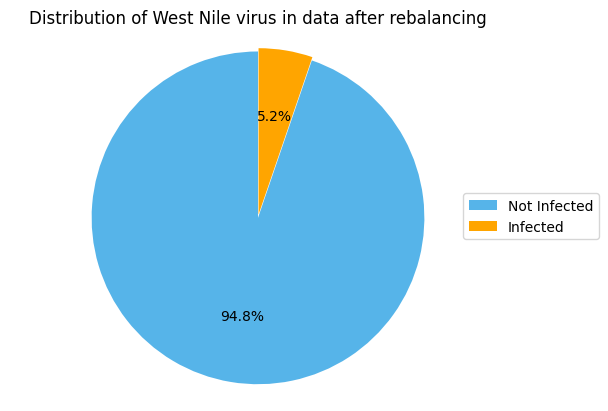

9955
551


In [15]:
target_value = target.value_counts()
labels = 'Not Infected', 'Infected'

sizes = [target_value[0], target_value[1]]
colors = ['#56B4E9', '#FFA500']
explode = (0, 0.02)

fig1, ax1 = plt.subplots()
wedges, texts, autotexts = ax1.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.title('Distribution of West Nile virus in data after rebalancing')
plt.legend(wedges, labels, loc="center left", bbox_to_anchor=(0.9, 0, 0.5, 1))

plt.show()

print(target_value[0])
print(target_value[1])

# Oversampling data

Oversampling is a resampling scheme where you modify the distribution of a variable in your dataset by artificially increasing the number of observations that take on a particular value or range of values for that variable. In most cases, this is done by looking at what values are underrepresented in the dataset and artificially increasing the number of observations that take on that value or range of values.

## Types of Oversampling Methods

There are two main types of oversampling methods:

- Duplicate Sampling: This method involves duplicating existing entries that are already present in the dataset to increase the presence of those entries.
- Synthetic Sampling: This method involves adding noise to the entries that already exist and creating new “synthetic” observations that resemble the existing observations.

##Advantages of Oversampling

Does not decrease the size of the dataset: Oversampling does not decrease the size of the dataset, which is important if you are using a complicated model with many parameters that need to be fit.
Does not lose any information: Oversampling ensures that you do not lose any information that is already present in the dataset, as all of the records that are contained in the initial dataset are also contained in the resampled dataset.

##Disadvantages of Oversampling

Can increase the chance of overfitting: Oversampling can increase the chance of your model overfitting to your training data, as you are introducing redundant information into the dataset.
Can lead to biased models: Oversampling can lead to biased models, as the increased presence of certain values or ranges of values can skew the model’s predictions.

# explanation of the oversampling method used with the library imbalanced learn

The oversampling method used in the code example, specifically RandomOverSampler from the imbalanced-learn library, works by randomly duplicating samples from the minority class (class 1) until the class distribution is balanced.

## Here's how it works step by step:

- Identify Minority Class: The oversampler first identifies which class is the minority class based on the provided target variable.

- Determine Oversampling Ratio: It then determines the number of samples needed to balance the classes. In this case, it's determined by the difference between the number of samples in the majority class (class 0) and the minority class (class 1).

- Randomly Sample Minority Class: The oversampler randomly selects samples from the minority class to duplicate until it reaches the desired balance. This process is random, meaning it randomly selects samples from the minority class and duplicates them, possibly multiple times, until the desired balance is achieved.

- Create Oversampled Dataset: After oversampling, it combines the original majority class samples with the duplicated minority class samples to create an oversampled dataset.

By doing this, the oversampling method ensures that both classes have an equal representation in the dataset, which can help improve the model's performance, especially when dealing with highly imbalanced datasets.

In [37]:
# Step 1: Split the data
train_X, test_X, train_Y, test_Y = train_test_split(train, target, test_size=0.2)

Applying a Duplicate Oversampling method

In [38]:
from imblearn.over_sampling import RandomOverSampler

# Assuming X_train and y_train are your feature and target variables
# X_train.shape = (number_of_samples, number_of_features)
# y_train.shape = (number_of_samples,)

# Instantiate the RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Step 2: Apply oversampling to training data only
# Fit and apply the oversampling , randomly duplicating samples from the minority class (class 1) until the class distribution is balanced.
X_train_resampled, y_train_resampled = oversampler.fit_resample(train_X, train_Y)

# Now X_resampled and y_resampled contain the oversampled data



Applying a Synthetic Oversampling method

In [39]:
from imblearn.over_sampling import SMOTE

# Step 2: Apply a synthetic oversampling method called SMOTE for oversampling to training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(train_X, train_Y)

Now the target features is evenly distributed

 X_train_resampled.shape[0] =  15940
 Y_train_resampled.shape[0] =  15940


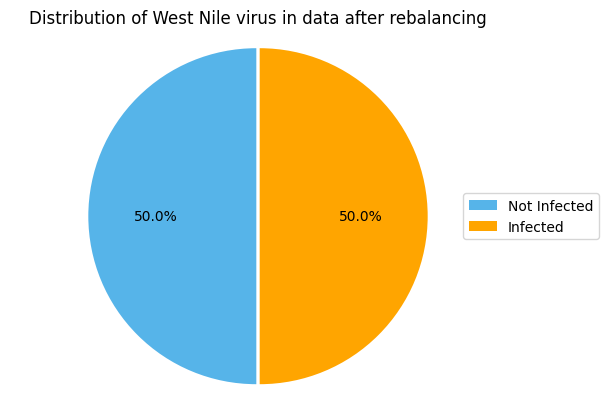

7970
7970


In [32]:
print(f" X_train_resampled.shape[0] =  {X_train_resampled.shape[0]}" )
print(f" Y_train_resampled.shape[0] =  {X_train_resampled.shape[0]}" )

target_value = y_train_resampled.value_counts()
labels = 'Not Infected', 'Infected'

sizes = [target_value[0], target_value[1]]
colors = ['#56B4E9', '#FFA500']
explode = (0, 0.02)

fig1, ax1 = plt.subplots()
wedges, texts, autotexts = ax1.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.title('Distribution of West Nile virus in data after rebalancing')
plt.legend(wedges, labels, loc="center left", bbox_to_anchor=(0.9, 0, 0.5, 1))

plt.show()

print(target_value[0])
print(target_value[1])

In [48]:
# Step 3: Train your model on the oversampled training data
'''model = Sequential([
    Dense(10, activation='relu', input_dim=train_X.shape[1]),
    Dense(1, activation='sigmoid')
])

model.summary()'''


model = Sequential([
    Dense(32, activation='relu', input_dim=train_X.shape[1]),
    Dropout(0.5),
    Dense(32, activation='relu', input_dim=train_X.shape[1]),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

'''X, y = shuffle(X, y)
X, scaler = preprocess_data(X)
Y = to_categorical(y)'''



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 32)                1056      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2145 (8.38 KB)
Trainable params: 2145 (8.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


'X, y = shuffle(X, y)\nX, scaler = preprocess_data(X)\nY = to_categorical(y)'

In [50]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
model.fit(train_X, train_Y, epochs=20, validation_split=0.2)

Epoch 1/20
211/211 [==============================] - 2s 3ms/step - loss: 79.3037 - accuracy: 0.8078 - val_loss: 28.8846 - val_accuracy: 0.9375
Epoch 2/20
211/211 [==============================] - 1s 2ms/step - loss: 17.7869 - accuracy: 0.8807 - val_loss: 7.2046 - val_accuracy: 0.9375
Epoch 3/20
211/211 [==============================] - 1s 2ms/step - loss: 3.4203 - accuracy: 0.8838 - val_loss: 0.2492 - val_accuracy: 0.9375
Epoch 4/20
211/211 [==============================] - 1s 2ms/step - loss: 0.3929 - accuracy: 0.9113 - val_loss: 0.2585 - val_accuracy: 0.9375
Epoch 5/20
211/211 [==============================] - 1s 3ms/step - loss: 0.2796 - accuracy: 0.9360 - val_loss: 0.2363 - val_accuracy: 0.9375
Epoch 6/20
211/211 [==============================] - 0s 2ms/step - loss: 0.2333 - accuracy: 0.9476 - val_loss: 0.2310 - val_accuracy: 0.9375
Epoch 7/20
211/211 [==============================] - 1s 3ms/step - loss: 0.2146 - accuracy: 0.9475 - val_loss: 0.2298 - val_accuracy: 0.9375
Epo

In [52]:
# Step 4: Evaluate your model on the untouched test set
loss, accuracy = model.evaluate(test_X, test_Y)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

66/66 [==============================] - 0s 2ms/step - loss: 0.2011 - accuracy: 0.9491
Test loss: 0.20113931596279144
Test accuracy: 0.9490960836410522


In [53]:
predictions = model.predict(test)
predictions = (predictions > 0.5).astype(int)
submission = pd.DataFrame({
    'Id': test_id,  # Assurez-vous que 'Id' est correctement conservé dans test_merged
    'WnvPresent': predictions.flatten()  # Assurez-vous que les prédictions sont au bon format
})
submission

3635/3635 [==============================] - 5s 1ms/step


,Id,WnvPresent
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
...,...,...
116288,116289,1
116289,116290,1
116290,116291,1
116291,116292,1


In [54]:
submission.to_csv('submission.csv', index=False)